<a href="https://colab.research.google.com/github/arielya/HangingRopeProblem/blob/main/Hanging_rope_under_its_own_weight_and_aerodynamic_loads_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<h1 align="center">Hanging rope under its own weight and aerodynamic loads</h1>
<h3 align="center">Ariel Yaniv</h3>
<h4 align="center">ariel.yaniv@gmail.com</h3>

This code was created in reference to this article. For more information about the modeling and equation please see the article in the link.

## The diffrential equations

The diffrential equations of the rope segment are:
$$
\begin{align}
  &\frac{\mathrm{d}H(x)}{\mathrm{d}x} = q \left(c_\perp \frac{V^3}{H^3} + c_\parallel \right) \frac{1}{1 + \frac{V^2}{H^2}} \\
  &\frac{\mathrm{d}V(x)}{\mathrm{d}x} = \sqrt{1 + \frac{V^2}{H^2}} q_w  - q \left(c_\perp \frac{V}{H} - c_\parallel \right) \frac{\frac{V}{H}}{1 + \frac{V^2}{H^2}}
\end{align}
$$

Discretization of these differential equations will follow this discretization scheme:

$$
\begin{align}
  &\frac{\mathrm{d}H(x)}{\mathrm{d}x} = \frac{H_{i+1} - H_i}{\Delta x} \\
  &\frac{\mathrm{d}V(x)}{\mathrm{d}x} = \frac{V_{i+1} - V_i}{\Delta x} \\
  & H = \frac{H_{i+1} + H_i}{2} \\
  & V = \frac{V_{i+1} + V_i}{2} \\
\end{align}
$$

Which finally can be written as follow:

$$
\begin{align}
  &h := 0 = \frac{H_{i+1} - H_i}{\Delta x}
    - q \left(c_\perp \frac{(V_{i+1} + V_i)^3}{(H_{i+1} + H_i)^3} + c_\parallel \right) \frac{1}{1 + \frac{(V_{i+1} + V_i)^2}{(H_{i+1} + H_i)^2}} \\
  &v := 0 =\frac{V_{i+1} - V_i}{\Delta x} 
    - q_w \sqrt{1 + \frac{(V_{i+1} + V_i)^2}{(H_{i+1} + H_i)^2}} + q \left(c_\perp \frac{V_{i+1} + V_i}{H_{i+1} + H_i} - c_\parallel \right) \frac{\frac{V_{i+1} + V_i}{H_{i+1} + H_i}}{1 + \frac{(V_{i+1} + V_i)^2}{(H_{i+1} + H_i)^2}}
\end{align}
$$

## Initialization

The physical constants and the materials properties are summarized in the table below:

| symbole        | value  | unit       |
|----------------|--------|------------|
| $g$            | 9.81   | [m/$s^2$]  |
| $m_{rope}$     | 50     | [kg]       |
| $l_{rope}$     | 15     | [m]        |
| $D_{rope}$     | 0.07   | [m]        |
| $\rho$         | 1.2250 | [kg/$m^3$] @ 15$^\circ$ C|
| $c_{parallel}$ | 0.05$\pi$| [-] (ref. [1])|
| $c_{perp}$     | 1.17   | [-] (ref. [3])|
| $m_{weight}$   | 16     | [kg]       |
| $D_{parachute}$| 0.40   | [m]        |
| $c_{parachute}$| 1-1.75 | [-] (ref. [1])|


The $x$ axis will be discretizied with equal distance. The step is:
$$
\Delta x = 0.0001
$$

In [1]:
import numpy as np
from scipy.optimize import fsolve

import matplotlib.pyplot as plt

In [2]:
# Gravity of Earth
g = 9.81 # [m/s]

# Rope properties
m = 50    # [m]
l = 15    # [kg]
D = 0.07  # [m]
q_w = m*g/l
print("the rope force per meter length is: {:.2f} N/m".format(q_w))

# Aerodynamic coefficients of the rope
c_rec = 1.2         # [-] 
c_par = 0.05*np.pi  # [-] 

# Flight speed and air properties
rho = 1.12250 # [kg/m^3]
U = 100/3.6   # [m/s]
q = 0.5 * D * rho * U**2

# External weight properties
m_weight = 16 # [kg]

# parachute properties and drag
D_parachute = 0.5   # [m]
cd_parachute = 1.0  # [-] 
F_parachute = 0.5 * rho * cd_parachute * (np.pi * D_parachute**2 / 4) * U**2
print("the parachute force at the end of the rope is {:.2f} N".format(F_parachute))

# Discretization
dx = 0.0001

the rope force per meter length is: 32.70 N/m
the parachute force at the end of the rope is 85.03 N


In [3]:
def plot_rope(Y_just_rope, Y_with_weight, Y_with_parachute):
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,10), dpi=220, sharey=True, sharex=True)
    #fig.suptitle('Rope shape')
    ax1.plot([i*dx for i in range(len(Y_just_rope))], Y_just_rope, linewidth=4)
    ax1.title.set_text('just rope')
    ax1.get_yaxis().set_visible(False)
    ax2.plot([i*dx for i in range(len(Y_with_weight))], Y_with_weight,linewidth=4)
    ax2.title.set_text('with weight')
    ax3.plot([i*dx for i in range(len(Y_with_parachute))], Y_with_parachute,linewidth=4)
    ax3.title.set_text('with parachute')

    ax1.set_aspect('equal')
    ax2.set_aspect('equal')
    ax3.set_aspect('equal')

    plt.show()

# Solving using *fsolve*

First, this differential equation will be solved with the SciPy package `fslove`. As you will see below, `fslove` suggests a very easy-to-use solution. The only requirement for the user is to create a function with the discretized differential equation (see `equations`) and ask for the solution. 

In the next cell the differential equations are defined exactly as above with no changes:

In [4]:
def rope_diff_equations(p, *data):
    h_i1, v_i1 = p
    h_i, v_i = data
    
    hm = (h_i1 + h_i)/2
    vm = (v_i1 + v_i)/2
    
    vh = vm / hm
    
    h = (h_i1 - h_i)/dx - q*(c_rec*vh**3 + c_par)/(1 + vh**2)
    v = (v_i1 - v_i)/dx - q_w*(1 + vh**2)**0.5 + q*(c_rec*vh - c_par)*vh/(1+vh**2)
    
    return (h, v)

The code below iterates over the rope segments $i$ and calculate in every iteration the next segment $i+1$. This will iterate until the rope length will be reached.

In [5]:
def fsolve_algorithm(h0, v0):
    H = [h0]
    V = [v0]
    
    alpha = [np.arctan2(H[0], V[0])]
    Y = [0]
    S = [0]

    i = 1
    while S[-1] < l:
        data = (H[i-1], V[i-1])
        hi, vi =  fsolve(rope_diff_equations, (10, 10), args=data)
        H.append(hi)
        V.append(vi)
        #dy = dx * (vi / hi)
        dy = dx * ((vi + V[i-1]) / (hi+H[i-1]))
        Y.append(Y[i-1] + dy)
        alpha.append(np.arctan2(vi, hi))
        S.append(S[i-1] + np.sqrt(dx**2 + dy**2))
        i += 1
        
    return Y

Finally, the rope forces and geometry will be calculated for the three cases:
 * Rope with no weight or parachute: $H_0 = V_0 = 0$
 * Rope with weight: $H_0 = 0$ and $V_0 = F_{weight}$
 * Rope with parachute: $H_0 = F_{parachute}$ and $V_0 = 0$

The force that is applied by a weight by the end of the rope is simply the weight multiplied by the gravity of Earth.

In [6]:
# rope with no weight or parachute
Y_just_rope = fsolve_algorithm(0, 0)

# rope with weight
Y_with_weight = fsolve_algorithm(0, m_weight * g)

# rope with parachute
Y_with_parachute = fsolve_algorithm(F_parachute, 0)

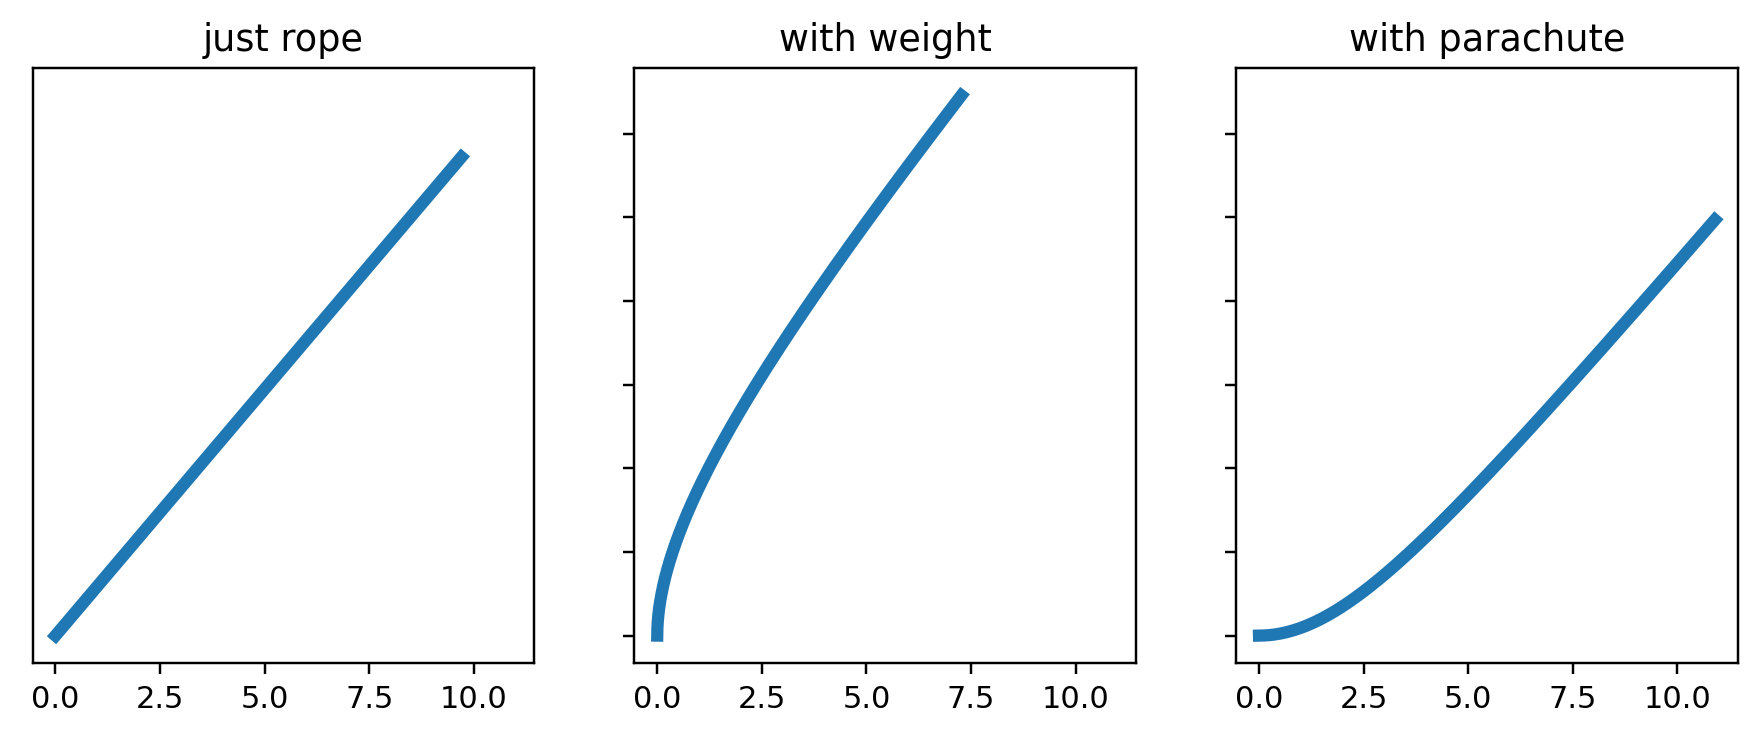

In [7]:
plot_rope(Y_just_rope, Y_with_weight, Y_with_parachute)

# Custom Solver with Newton Raphson Method

The Newton Raphson Method for a multivarible eqauation is defind as follow:

$$
\begin{equation}
 \vec{x}_{n+1} = \vec{x}_n - [J_f(x_n)]^{-1} \cdot \vec{f}(x_n)
\end{equation}
$$

Where $J$ is the Jacobi matrix and $J^{-1}$ is the inverse of the Jacobi matrix.

The Newton Raphson Method requires the derivation of each equation with respect to each variable. This is the Jacobi matrix, which in our case is 4 by 4, since there are 2 equations and two variables. To simplify the notation of derivative a variable $t$ will suggested:

$$
\begin{align}
  &t = \frac{V_{i+1} + V_i}{H_{i+1} + H_i}
\end{align}
$$

Using the variable $t$ will lead to the following equations:
$$
\begin{align}
  &h:=0 = \frac{H_{i+1} - H_i}{\Delta x}
    - q \left(c_\perp t^3 + c_\parallel \right) \frac{1}{1 + t^2} \\
  &v:=0 = \frac{V_{i+1} - V_i}{\Delta x} 
    - q_w \sqrt{1 + t^2} + q \left(c_\perp t - c_\parallel \right) \frac{t}{1 + t^2}
\end{align}
$$

The derivative are defined as follow:
$$
\begin{align}
  &\frac{\partial h}{\partial H_{i+1}} = \frac{1}{\Delta x}
    - q\frac{}{}\frac{\partial t}{\partial H_{i+1}}\frac{t}{(1 + t^2)^2} \left[c_\perp (3t + t^3) -2 c_\parallel \right]  \\
    &\frac{\partial h}{\partial V_{i+1}} = 
    - q\frac{}{}\frac{\partial t}{\partial V_{i+1}}\frac{t}{(1 + t^2)^2} \left[c_\perp (3t + t^3) -2 c_\parallel \right]  \\
\end{align}
$$

$$
\begin{align}
  &\frac{\partial v}{\partial H_{i+1}} = 
    \frac{\partial t}{\partial H_{i+1}} \left\{-q_w\frac{t}{\sqrt{1+t^2}} + q\frac{1}{(1+t^2)^2}\left[c_\perp 2t - c_\parallel(1-t^2)\right]  \right\}\\
  &\frac{\partial v}{\partial V_{i+1}} = 
    \frac{1}{\Delta x} +
    \frac{\partial t}{\partial H_{i+1}} \left\{-q_w\frac{t}{\sqrt{1+t^2}} + q\frac{1}{(1+t^2)^2}\left[c_\perp 2t - c_\parallel(1-t^2)\right]  \right\}
\end{align}
$$

Finally, the derivative are creating the Jacobi matrix:

$$
\begin{equation}
 J = 
 \begin{bmatrix}
 \frac{\partial h}{\partial x_1} & \frac{\partial h}{\partial x_2} \\
 \frac{\partial v}{\partial x_2} & \frac{\partial v}{\partial x_2}  \\
 \end{bmatrix}
\end{equation}
$$

Fortunatly, the NumPy function `linalg.inv` can be used to calculate the inverse of the Jacobi matrix.

In [8]:
# the Jacbi matrix
def Jf(H_i1, V_i1, Hi, Vi):
    t = (V_i1 - Vi) / (H_i1 - Hi)
    
    dt_dH = - (V_i1 - Vi) / (H_i1 - Hi)**2
    dt_dV = 1 / (H_i1 - Hi)
    
    dh_dH = 1/dx - q * dt_dH * t * (c_rec*(3 + t**2)*t - 2*c_par) / (1+t**2)**2
    dh_dV =      - q * dt_dV * t * (c_rec*(3 + t**2)*t - 2*c_par) / (1+t**2)**2
    
    dv_dH = - q_w * dt_dH * t / (1+t**2)**0.5 \
            + q * dt_dH * (c_rec*2*t - c_par*(1-t**2)) / (1+t**2)**2

    dv_dV = 1/dx - q_w * dt_dV * t / (1+t**2)**0.5 \
            + q * dt_dV * (c_rec*2*t - c_par*(1-t**2)) / (1+t**2)**2

    return np.array([[dh_dH, dh_dV], [dv_dH, dv_dV]])

In [9]:
# the rope differential equations:
def fvec(h_i1, v_i1, h_i, v_i):
    
    hm = (h_i1 + h_i)/2
    vm = (v_i1 + v_i)/2
    
    vh = vm / hm
    
    h = (h_i1 - h_i)/dx - q*(c_rec*vh**3 + c_par)/(1 + vh**2)
    v = (v_i1 - v_i)/dx - q_w*(1 + vh**2)**0.5 + q*(c_rec*vh - c_par)*vh/(1+vh**2)
    
    return np.array([h, v])

The Newton Raphson Method iterates until the solution is converged. The solution coverage when the iteration over the next step does not change by more than a pre-defined residual. In this case, the residual was set to be $10^{-6}$.

In [10]:
# help function
def apply_newton_method(h_i, v_i):
    residual = 1e-6

    x_n = [h_i+1, v_i+1]

    x_n_pervious = [0, 0]
    while abs(x_n[0] - x_n_pervious[0]) > residual or abs(x_n[1] - x_n_pervious[1]) > residual:
    #for i in range(20):
        x_n_pervious[0] = x_n[0]
        x_n_pervious[1] = x_n[1]
        x_n = x_n - np.dot(np.linalg.inv(Jf(x_n[0], x_n[1], h_i, v_i)), fvec(x_n[0], x_n[1], h_i, v_i))

    return x_n

Eventually, the algorithm to solve the rope differential equations:

In [11]:
def nrm_algo(h0, v0):
    H = [h0]
    V = [v0]
    
    alpha = [np.arctan2(H[0], V[0])]
    Y = [0]
    S = [0]

    #for i in range(1,steps):
    i = 1
    while S[-1] < l:
        #data = (H[i-1], V[i-1])
        hi, vi = apply_newton_method(H[i-1], V[i-1])
        H.append(hi)
        V.append(vi)
        dy = dx * (vi / hi)
        Y.append(Y[i-1] + dy)
        alpha.append(np.arctan2(vi, hi))
        S.append(S[i-1] + np.sqrt(dx**2 + dy**2))
        i += 1
        
    return Y

Calculating the geometry of the rope for the 3 cases:

In [12]:
# rope with no weight or parachute
Y_just_rope = nrm_algo(0, 0)

# rope with weight
Y_with_weight = nrm_algo(0, m_weight * g)

# rope with parachute
Y_with_parachute = nrm_algo(F_parachute, 0)

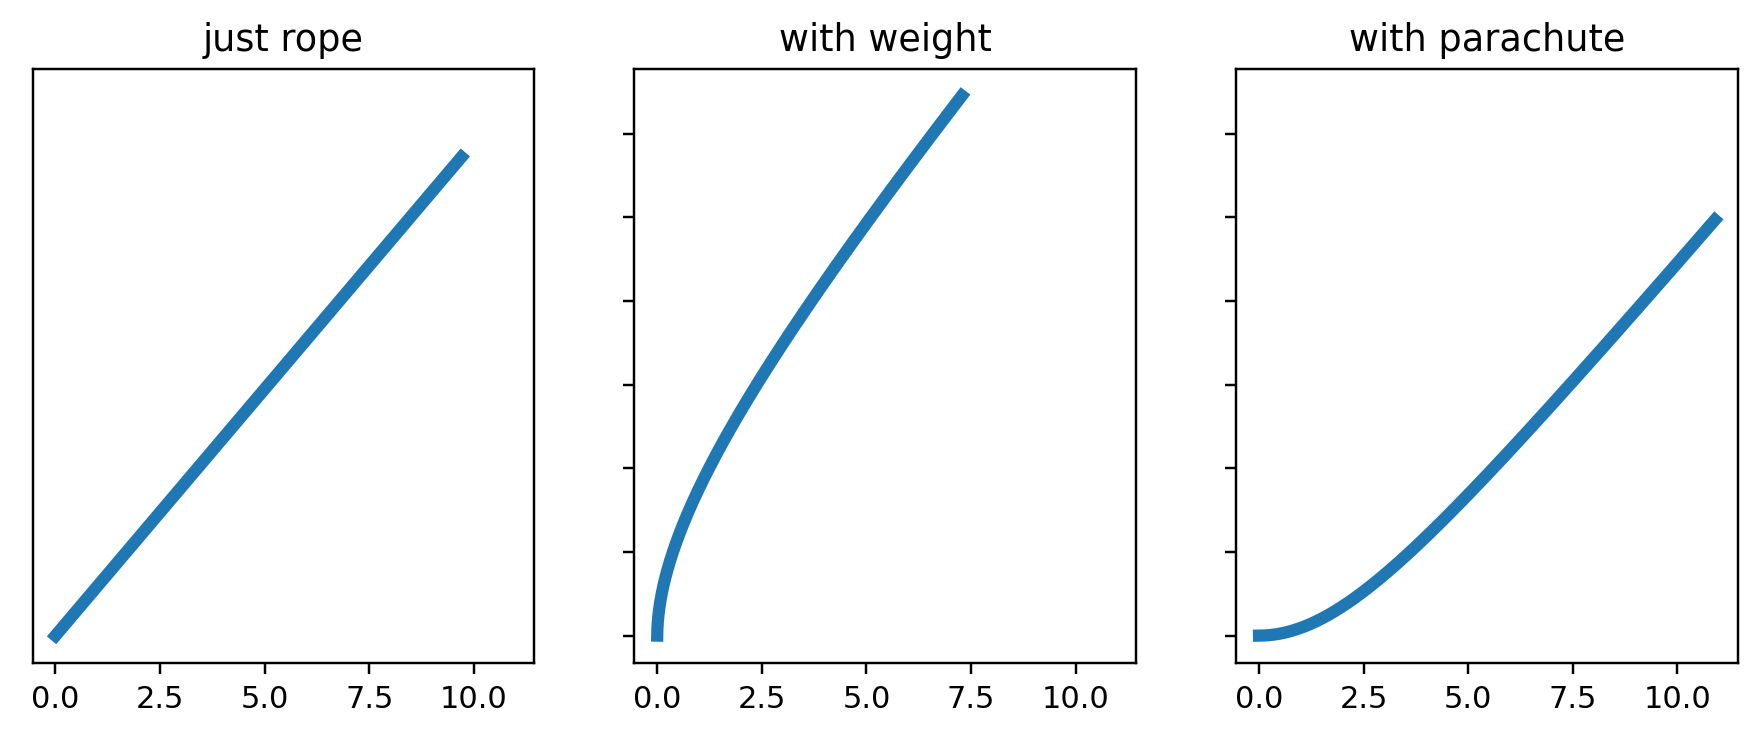

In [13]:
plot_rope(Y_just_rope, Y_with_weight, Y_with_parachute)